# SIGNAL PROCESSING TP3 - M2 AI
## To Do: noise spectrum density estimation and Wiener filtering

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

---

## IMPORT

In [1]:
import numpy as np
from PIL import Image
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.signal import stft, istft
from scipy.signal import periodogram, welch
from scipy import fftpack
from IPython.display import Audio

# 1: Periodogram and Welch

In [2]:
def create_periodogram_and_welch(filename):
    """
    Estimate the spectral density of a given noise file using both the periodogram and Welch methods. 
    
    Parameters:
    - filename: Path to the noise file.
    
    Returns:
    - Slope of the PSD in the log-log scale.
    """
    noise, sample_rate = sf.read(filename)

    # Estimate the spectrum density using periodogram
    f_periodogram, p_periodogram = periodogram(noise, fs=sample_rate)

    # Estimate the spectrum density using Welch method
    f_welch, p_welch = welch(noise, fs=sample_rate, nperseg=1024)

    # Compute the slope for the Welch PSD in log-log scale
    log_freq = np.log10(f_welch[1:])   
    log_Pxx = np.log10(p_welch[1:])

    # Linear fit to find the slope and intercept
    slope, intercept = np.polyfit(log_freq, log_Pxx, 1)

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    fig.suptitle(f'Spectrum Density of {filename}', fontsize=16, y=1.02)
    
    axs[0].semilogy(f_periodogram, p_periodogram)
    axs[0].set_title(f'Periodogram method plot')
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Power/Frequency (dB/Hz)')
    axs[0].grid()
    
    axs[1].loglog(f_welch, p_welch, label="Original Data")
    axs[1].loglog(f_welch[1:], 10**(intercept + slope*log_freq), 'r--', label=f"Linear fit (Slope: {slope:.2f})")
    axs[1].set_title(f'Log-Log Welsh method plot with Linear Fit')
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Power/Frequency (dB/Hz)')
    axs[1].legend()
    axs[1].grid(which='both')
    
    plt.tight_layout()
    plt.show()

    return slope

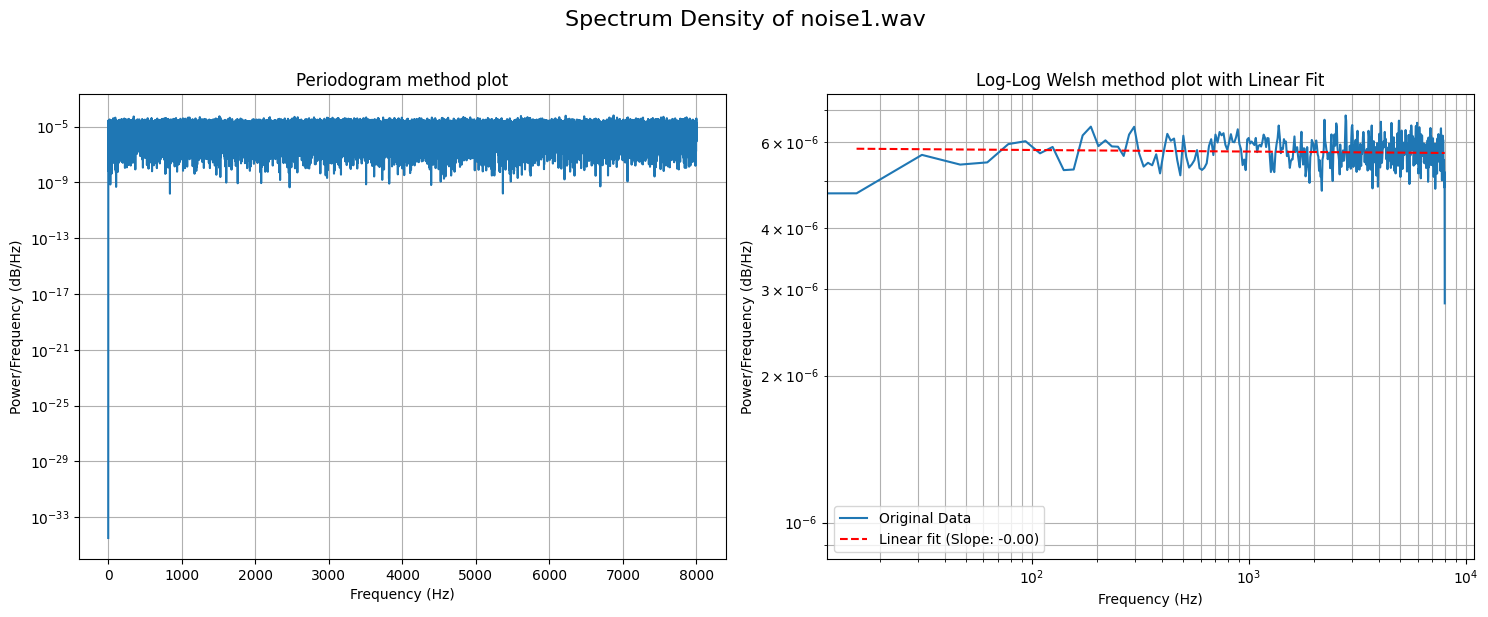

[noise1.wav] The color of the noise is White with slope of -0.003196690320716558


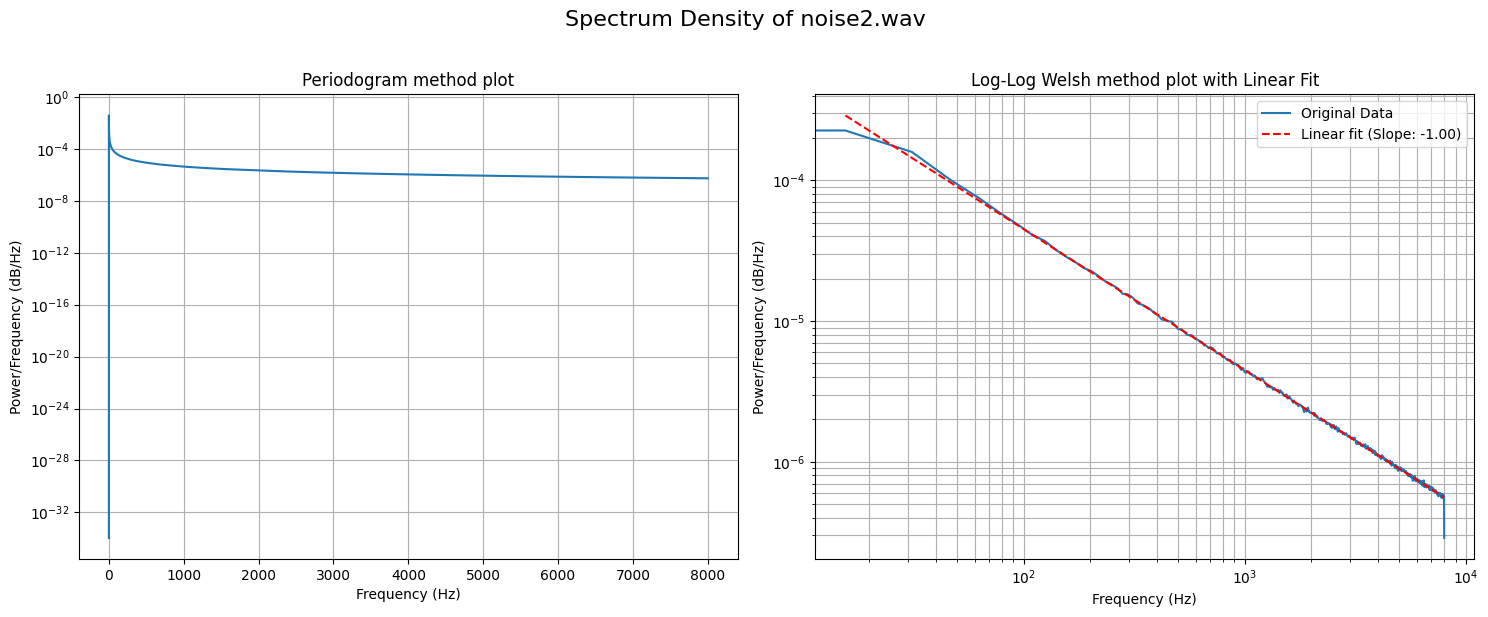

[noise2.wav] The color of the noise is Pink (or 1/f noise) with slope of -1.0017960536667927


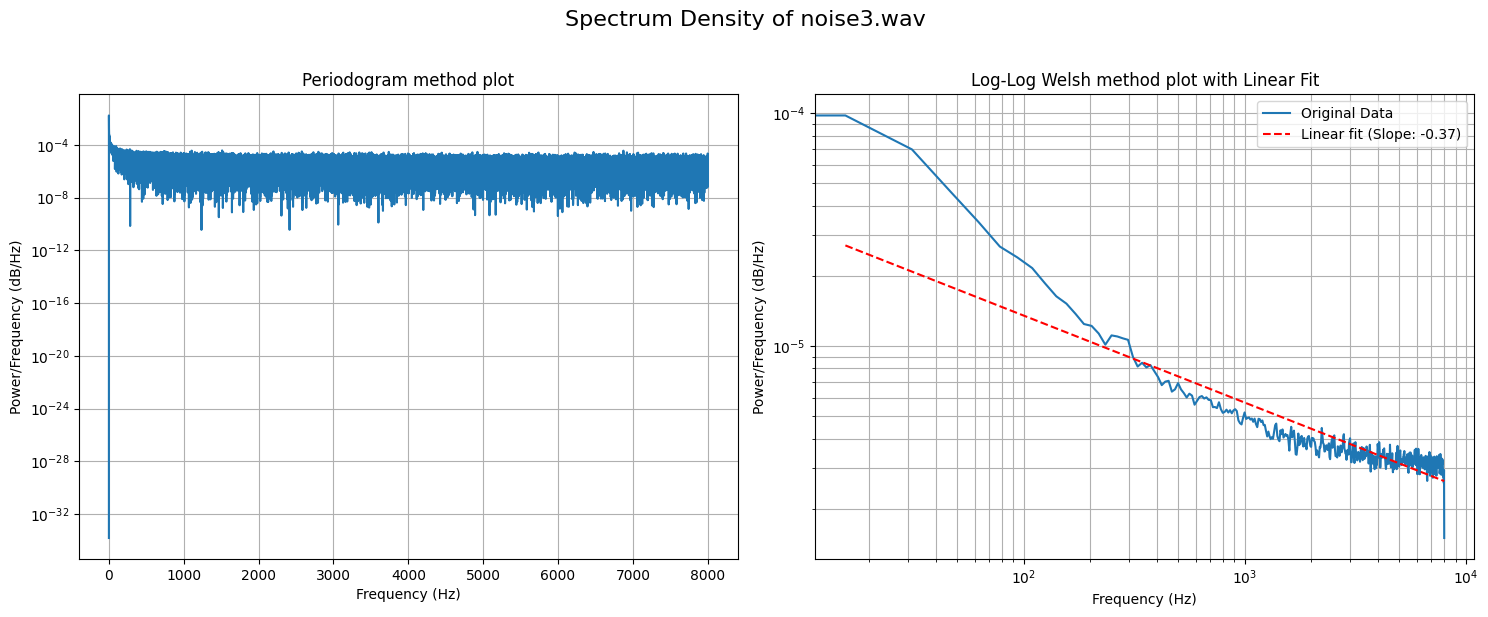

[noise3.wav] The color of the noise is White and Pink with slope of -0.37351257318087955


In [3]:
FILES = ["noise1.wav", "noise2.wav", "noise3.wav"]
ANSWERS = ["White", "Pink (or 1/f noise)", "White and Pink"]

for f,a in zip(FILES, ANSWERS):
    slope = create_periodogram_and_welch(f)
    print(f"[{f}] The color of the noise is {a} with slope of {slope}")

### Periodogram:
- The periodogram is a simple method for estimating the power spectral density (PSD) of a signal.
- While it's straightforward and easy to compute, the periodogram often suffers from high variance, meaning that its values can fluctuate significantly for different realizations of the same process.
- This variance can sometimes make it difficult to interpret the true underlying spectral content of a signal.

### Welch Method:
- The Welch method is an improved method for estimating the PSD that reduces the variance of the periodogram.
- It involves dividing the signal into overlapping segments, computing a modified periodogram for each segment, and then averaging these periodograms.
- By averaging the periodograms of multiple segments, the Welch method reduces the variance and provides a smoother and more reliable estimate of the PSD.

### Interesting finding (coincidence)
When we add the power spectrum of `noise1.wav` and `noise2.wav`, we have a slope of `-0.40` which is approximately equivalent with `noise3.wav`

---

# 2: Image denoising 

Please refer to the section 3 for an explanation of the algorithm. (both Wiener filters are the same except this one uses 2 dimensional fft).

The only difference is the computation of the estimator of the Power Spectrum of the random noise , defined by its variance: 
$$
SNR = 10 \log_{10} \left( \frac{E\left( \left| S\right|^2 \right)}{E\left( \left| N\right|^2 \right)} \right)
$$
N being the noise and S the original signal.

However as our noise is Gaussian and centered around 0, $E\left( \left| N\right|^2 - 0 \right)= \sigma_{noise}^2 $

$\sigma_n$ being the standard deviation of the noise.

Therefore: 
$$
SNR = 10 \log_{10} \left( \frac{E\left( \left| S\right|^2 \right)}{\sigma_{noise}^2} \right)
$$



Finally our estimator for the Noise can be written as:

$$
\sigma_n^2 = \frac{E\left( \left| S\right|^2 \right)}{10^{\frac{SNR}{10}}}
$$

$E\left( \left| S\right|^2 \right)$ will be estimated using a peridogram (as explained in section 3).

In [4]:
def add_gaussian_noise(image, desired_snr_db):
    """
    Adds Gaussian white noise to an image to achieve a desired SNR.
    
    Parameters:
    - image: Input image (2D numpy array).
    - desired_snr_db: Desired SNR in dB.
    
    Returns:
    - Noisy image.
    """
    image_float = image.astype(np.float32)
    
    # Calculate the power of the image
    n = image.shape[0]**2
    image_power = np.sum(image_float**2)/n
   
        
    # Calculate the power of the noise needed to achieve the desired SNR 
    noise_power = image_power / (10**(desired_snr_db / 10))
    
    # Generate Gaussian white noise, note that because its gaussian and centered around 0
    # the variance of the noise is equal to its power.
    noise_var_sq = noise_power
    noise_std = np.sqrt(noise_var_sq)
    noise = noise_std*np.random.normal(0, 1, image.shape)
    
    # Add the noise to the image
    #noisy_image = np.clip(image_float + noise, 0, 255).astype(np.uint8)
    noisy_image = image + noise
    
    #return the noisy image and the standard deviation of the noise
    return noisy_image, noise_std

In [5]:
def convolution2(x, h):
    return np.real(fftpack.ifft2(fftpack.fft2(x)*fftpack.fft2(h)))

In [6]:
def wiener_filter(noisy, clean, noise_std):
    """
    Denoise a noisy signal using the Oracle Wiener filter.
    
    Parameters:
    - noisy: Noisy signal.
    - clean: Clean signal (original).
    - noise: Noise signal that was added to the clean signal.
    - n_fft: FFT size for STFT.
    - hop_size: Hop size for STFT.
    
    Returns:
    - Denoised signal.
    """
    # Compute the Power Spectrum estimators for the clean signal with the periodogram:
    n = clean.shape[0]
    N = n**2
    
    Zxx_clean = fftpack.fft2(clean)
    Pxx_clean = (np.abs(Zxx_clean) ** 2) / N
    
    # Compute the Power Spectrum estimator for the noise :
    Zxx_noise = noise_std**2
    
    # Wiener filter definition
    G = np.real(fftpack.ifft2( Pxx_clean / ( Pxx_clean + Zxx_noise )))
    
    # Apply the filter
    Zxx_denoised = convolution2(G,noisy)
        
    return Zxx_denoised

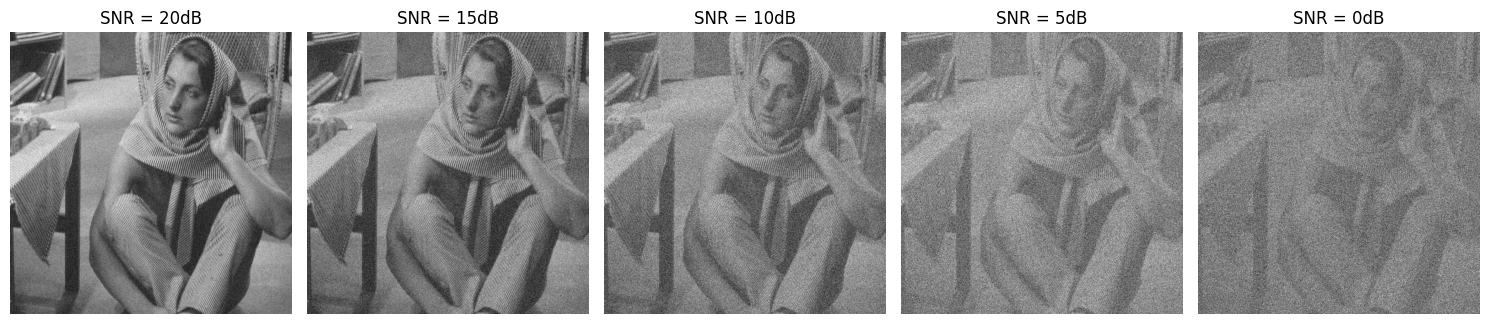

In [8]:
# List of desired SNR levels
snr_levels = [20, 15, 10, 5 , 0]
noisy_images = {}
noises_var={}

barbara_img = Image.open('barbara.jpg')
barbara_array = np.array(barbara_img.convert('L')) 

# Generate noisy images for each SNR level
for snr in snr_levels:
    noisy_images[snr], noises_var[snr] = add_gaussian_noise(barbara_array, snr)
    

# Display the noisy images
fig, axs = plt.subplots(1, len(snr_levels), figsize=(15, 15))
for ax, (snr, img) in zip(axs, noisy_images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"SNR = {snr}dB")
    ax.axis('off')

plt.tight_layout()
plt.show()


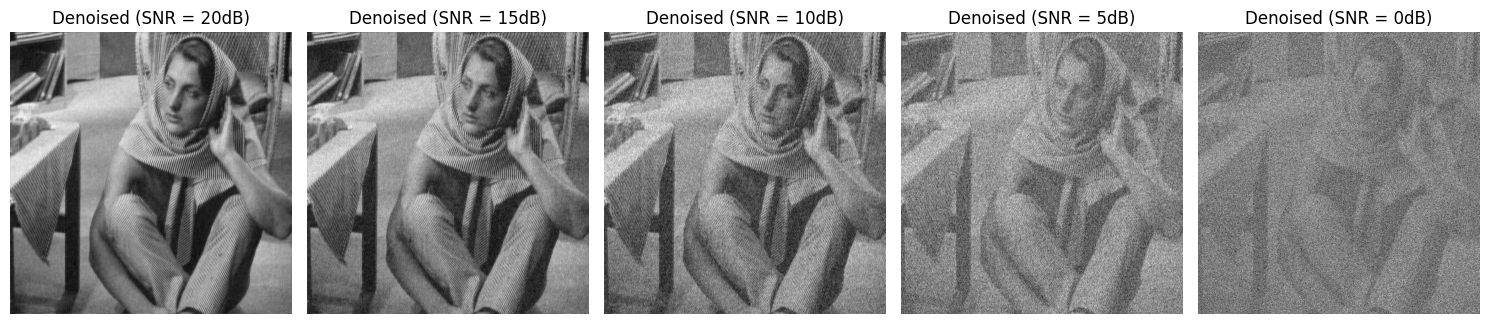

In [9]:
# Apply Wiener filter to denoise the images with different SNR levels
denoised_images = {}
for (snr, noisy_img), noise_v in zip(noisy_images.items(), noises_var):
    denoised_images[snr] = wiener_filter(noisy_img, barbara_array, noise_v)

fig, axs = plt.subplots(1, len(snr_levels), figsize=(15, 15))
for ax, (snr, img) in zip(axs, denoised_images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Denoised (SNR = {snr}dB)")
    ax.axis('off')

plt.tight_layout()
plt.show()

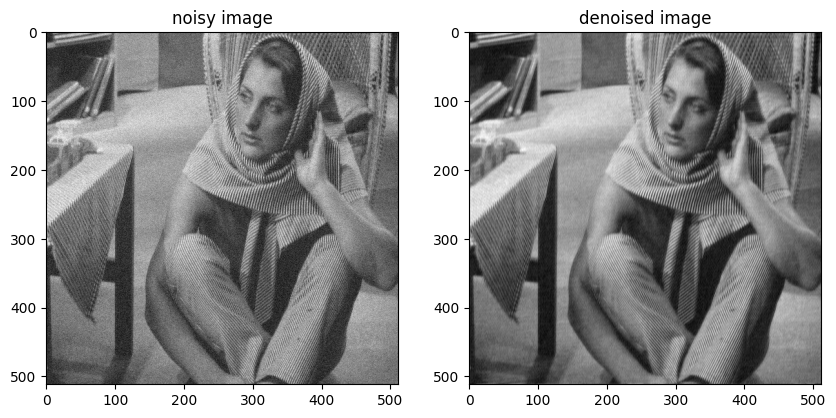

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(noisy_images[20], cmap='gray')
axs[0].set_title("noisy image")

axs[1].imshow(denoised_images[20], cmap='gray')
axs[1].set_title("denoised image")

plt.show()

---

# 3: Star Wars Music Denoising

Observation:
$ y = x + n $
where $ x $ is a clean signal and $ n $ is some noise.

Goal: Find a filter $ h $ such that 
$ x_{\text{est}} = h \ast y $
is a denoised estimation of $ x $ (The operation is a convolution).

The best filter, which maximizes the SNR, is the Wiener filter given in the frequency domain:
$ \hat{h}[k] = \frac{E\left( \left| \hat{x}[k] \right|^2 \right)}{E\left( \left| \hat{x}[k] \right|^2 \right) + E\left( \left| \hat{n}[k] \right|^2 \right)} $

Which can be rewritten as:

$\hat{h} = \frac{P_x}{P_x + \sigma_{noise}^2}$

Where $ P_x=E\left( \left| \hat{x}[k] \right|^2 \right) $ is the Power Spectrum of x and $\sigma_{noise}^2$ is the estimation of the Power Spectrum of the Gaussian noise, hence its variance.

We will be using an Oracle Wiener filter because in practice we don't have access to the clean signal.
We will be therefore be estimating the Power Spectrum of the clean signal using its known observed trajectory with the Periodogram (for N samples):

$S_{N}^{\text{Per}}(v) = \left| \sum_{n=0}^{N-1} x_{n} e^{i \frac{2\pi}{N}  v  n} \right|^2$

Which can be read in a more compact form:

$S_{N}^{\text{Per}}(v) = \left|\hat{x} \right|^2$

Where $\hat{x}$ is the fourier transform of the clean signal x.

We then take the averaged Periodogram (which reduces the variance) as the estimation of our Power Spectrum: 

${P_x} = \frac{1}{N} S_{N}^{\text{Per}}(v) = \frac{1}{N} \left|\hat{x} \right|^2$


Lets begin by defining a convolution, so we can apply the Wiener filter when denoising:

In [11]:
def convolution(x, h):
    return np.real(fftpack.ifft(fftpack.fft(x)*fftpack.fft(h)))

In [12]:
def oracle_wiener_denoise(noisy, clean, noise):
    """
    Denoise a noisy signal using the Oracle Wiener filter.
    
    Parameters:
    - noisy: Noisy signal.
    - clean: Clean signal (original).
    - noise: Noise signal that was added to the clean signal.
    - n_fft: FFT size for STFT.
    - hop_size: Hop size for STFT.
    
    Returns:
    - Denoised signal.
    """
    # Compute the Power Spectrum estimators for the clean signal:
    Zxx_clean = fftpack.fft(clean)
    Pxx_clean = (np.abs(Zxx_clean) ** 2) /len(clean)
    
    # Compute the Power Spectrum estimators for the noise :
    Zxx_noise = np.std(noise)
    
    # Oracle Wiener filter
    G = np.real(fftpack.ifft( Pxx_clean / ( Pxx_clean + Zxx_noise**2 ) ) )
    
    # Apply the filter
    Zxx_denoised = convolution(G,noisy)
        
    return Zxx_denoised

In [13]:
music1, sr_music = sf.read('music.wav')

# Noisy versions of the music with each noise
noisy_musics = {}
denoised_musics = {}
for i, noise_file in enumerate(['noise1.wav', 'noise2.wav', 'noise3.wav']):
    noise_data, _ = sf.read(noise_file)
    
    # Adjust the noise length to match the music length
    noise_data = np.resize(noise_data, music1.shape)
    
    # Add noise to the music with a global factor of 0.1
    noisy_music = music1 + 0.1 * noise_data
    noisy_musics[i] = noisy_music
    
    # Denoise using Oracle Wiener filter
    denoised_music = oracle_wiener_denoise(noisy_music, music1, 0.1 * noise_data)
    denoised_musics[i] = denoised_music

Testing to see if the noise is gone by listening:

In [14]:
Audio(music1, rate=sr_music)

In [15]:
Audio(noisy_musics[0], rate=sr_music)

In [16]:
Audio(denoised_musics[0], rate=sr_music)

Note: When playing the three sounds the noise is only noticeable in the noisy_music audio and not in the denoised audio. 

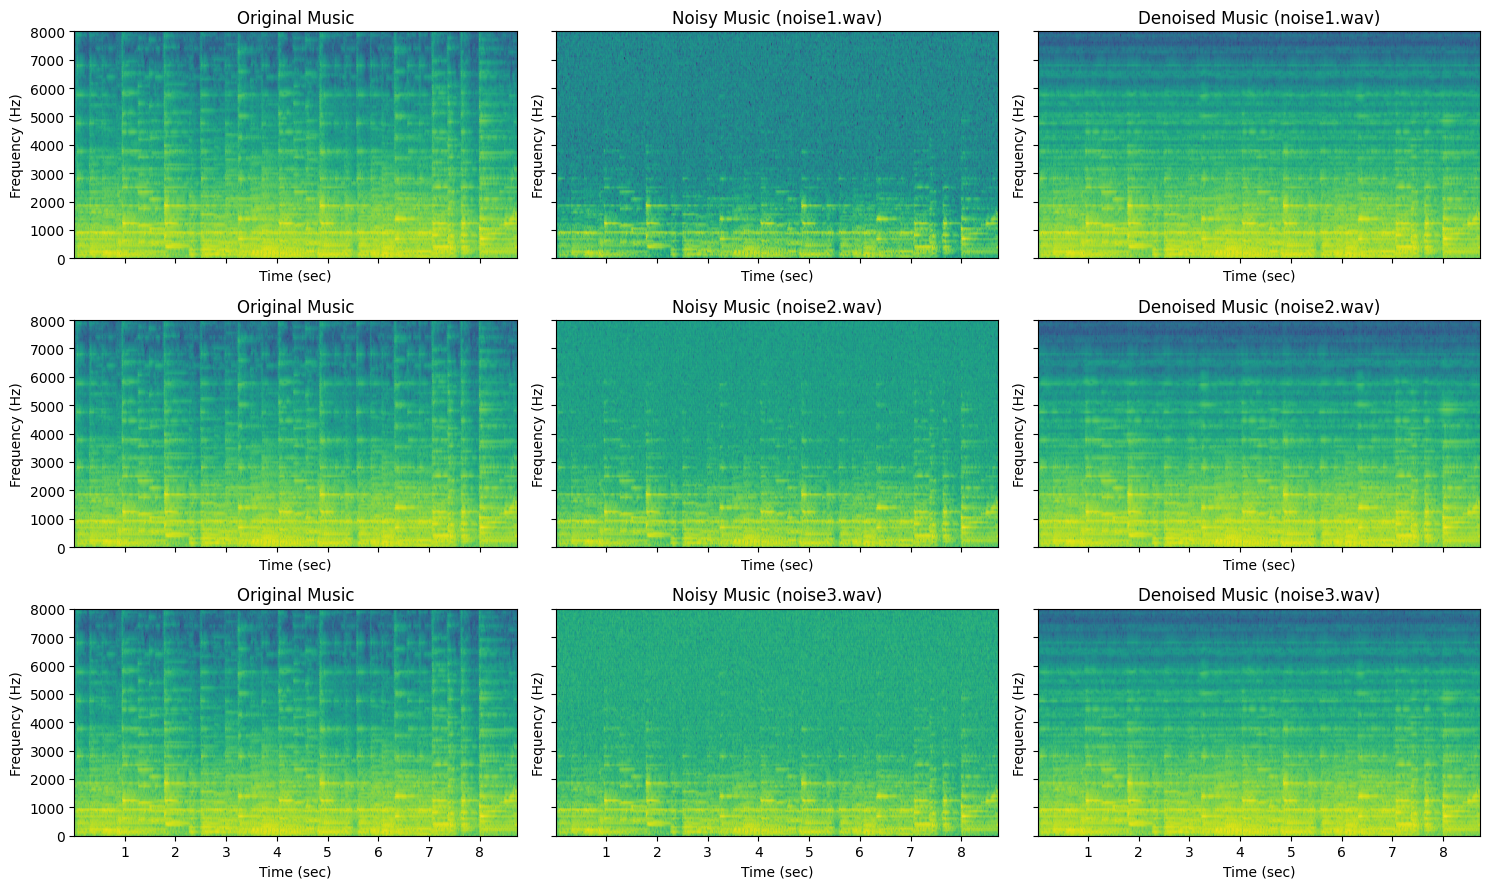

In [17]:
from scipy.signal import spectrogram

def plot_spectrogram(signal, sr, ax, title):
    """
    Plot the spectrogram of the given signal on the provided axis.
    """
    f, t, Sxx = spectrogram(signal, sr)
    ax.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (sec)')
    ax.set_title(title)

fig, axs = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# Spectrogram for original music
for ax in axs[:, 0]:
    plot_spectrogram(music1, sr_music, ax, "Original Music")

# Spectrogram for noisy and denoised music for each noise type
for i, (noise_name, ax_row) in enumerate(zip(['noise1.wav', 'noise2.wav', 'noise3.wav'], axs)):
    plot_spectrogram(noisy_musics[i], sr_music, ax_row[1], f"Noisy Music ({noise_name})")
    plot_spectrogram(denoised_musics[i], sr_music, ax_row[2], f"Denoised Music ({noise_name})")

plt.tight_layout()
plt.show()
